In [ ]:
#from google.colab import files
#uploaded = files.upload()

In [ ]:
import pandas as pd
import io

df = pd.read_csv(io.BytesIO(uploaded['final (2).csv']))

In [ ]:
print(df.head())


         Date   Open   High    Low  Close  Adj Close    Volume
0  2010-06-29  3.800  5.000  3.508  4.778      4.778  93831500
1  2010-06-30  5.158  6.084  4.660  4.766      4.766  85935500
2  2010-07-01  5.000  5.184  4.054  4.392      4.392  41094000
3  2010-07-02  4.600  4.620  3.742  3.840      3.840  25699000
4  2010-07-06  4.000  4.000  3.166  3.222      3.222  34334500


In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2956.000000,2956.000000,2956.000000,2956.000000,2956.000000,2.956000e+03
mean,138.691296,141.771603,135.425953,138.762183,138.762183,3.131449e+07
std,250.044839,255.863239,243.774157,250.123115,250.123115,2.798383e+07
min,3.228000,3.326000,2.996000,3.160000,3.160000,5.925000e+05
25%,19.627000,20.402000,19.127500,19.615000,19.615000,1.310288e+07
50%,46.656999,47.487001,45.820002,46.545000,46.545000,2.488680e+07
75%,68.057001,69.357500,66.911501,68.103998,68.103998,3.973875e+07
max,1234.410034,1243.489990,1217.000000,1229.910034,1229.910034,3.046940e+08


In [ ]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [ ]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
data = pd.read_csv("final.csv")

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])

In [ ]:
data.set_index('Date', inplace=True)

In [ ]:
# Split data into train and test sets
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

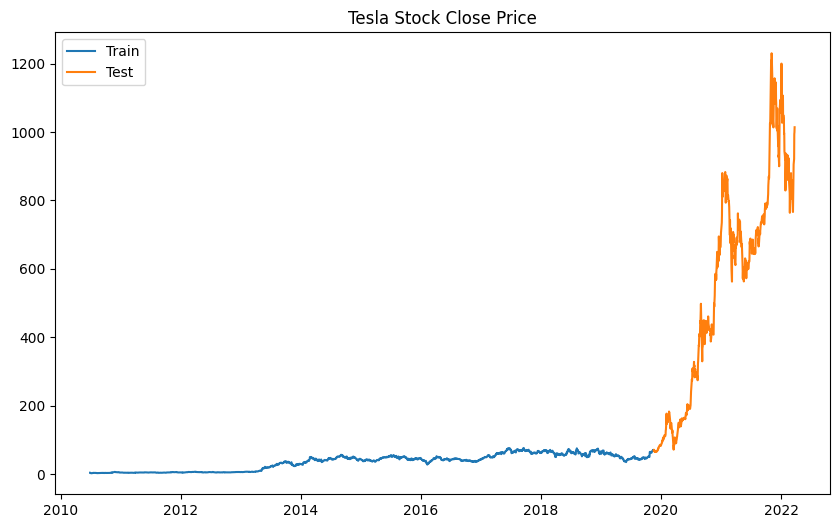

In [ ]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(train_data['Close'], label='Train')
plt.plot(test_data['Close'], label='Test')
plt.title('Tesla Stock Close Price')
plt.legend()
plt.show()

## GradientBoosting Model


In [ ]:
# Train GradientBoosting model
model_gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
model_gb.fit(X_train_rf, y_train)

# Make predictions
predictions_gb = model_gb.predict(X_test_rf)


In [ ]:
# Calculate RMSE, MAE, and MAPE for GradientBoosting
rmse_gb = np.sqrt(mean_squared_error(y_test, predictions_gb))
mae_gb = mean_absolute_error(y_test, predictions_gb)
mape_gb = np.mean(np.abs((y_test - predictions_gb) / y_test)) * 100

print("GradientBoosting RMSE:", rmse_gb)
print("GradientBoosting MAE:", mae_gb)
print("GradientBoosting MAPE:", mape_gb)



GradientBoosting RMSE: 8.479325904115132
GradientBoosting MAE: 7.648758833120239
GradientBoosting MAPE: 84.97820004176401


<ipython-input-72-a4ab96c6288e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['GradientBoostingPredictions'] = np.nan  # Initialize with NaN values


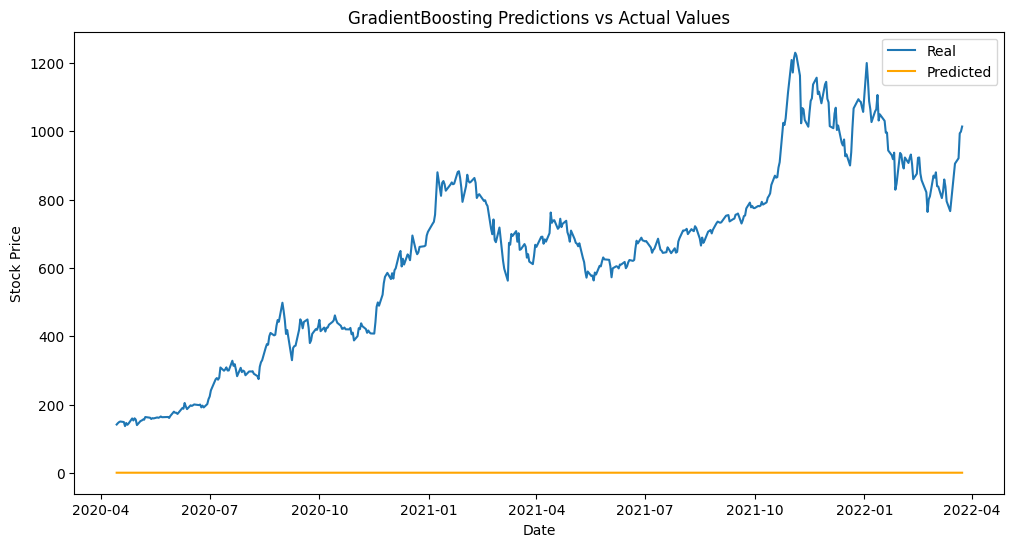

In [ ]:
# Add GradientBoosting predictions to test_data
test_data['GradientBoostingPredictions'] = np.nan  # Initialize with NaN values
test_data.loc[test_data.index[time_step:], 'GradientBoostingPredictions'] = predictions_gb  # Assign predictions to corresponding indices

# Plot GradientBoosting predictions
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test_data.index[time_step:], test_data['Close'][time_step:], label='Real')
plt.plot(test_data.index[time_step:], predictions_gb, color='orange', label='Predicted')
plt.title('GradientBoosting Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


## XG Boost

In [ ]:
import xgboost as xgb

# Define the XGBoost model
def xgboost_forecast(train_X, train_y, test_X):
    # Define parameters for XGBoost model
    params = {
        'objective': 'reg:squarederror',  # Regression task
        'colsample_bytree': 0.8,          # Subsample ratio of columns
        'learning_rate': 0.1,             # Step size shrinkage
        'max_depth': 5,                   # Maximum depth of a tree
        'alpha': 10,                      # L1 regularization term on weights
        'n_estimators': 100               # Number of boosted trees to fit
    }

    # Train the XGBoost model
    model = xgb.XGBRegressor(**params)
    model.fit(train_X, train_y)

    # Make predictions
    predictions = model.predict(test_X)
    return predictions

# Split data into train and test sets
X = pd.DataFrame({'ds': data.index, 'y': data['Close']})
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

# Convert train and test data into arrays
train_X, train_y = train['ds'].values.astype(np.int64), train['y'].values
test_X, test_y = test['ds'].values.astype(np.int64), test['y'].values

# Initialize empty list to store predictions
predictions = []

# Iterate through test data
for t in range(len(test_X)):
    # Generate a prediction
    yhat = xgboost_forecast(train_X.reshape(-1, 1), train_y, np.array([[test_X[t]]]))
    predictions.append(yhat[0])
    # Add another value to the training set
    train_X = np.append(train_X, test_X[t])
    train_y = np.append(train_y, test_y[t])

test_data.loc[:,'XGBoostPredictions'] = predictions


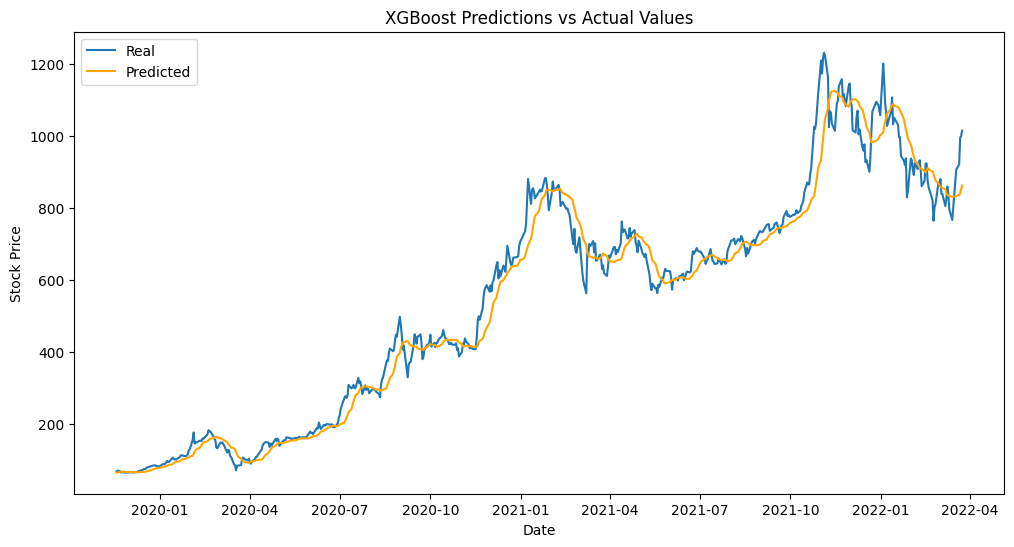

In [ ]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test_data.index,test_data.Close, label='Real')
plt.plot(test_data.index,test_data.XGBoostPredictions, color='orange', label='Predicted')
plt.title('XGBoost Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
test_data_4=test_data.dropna()
mse4 = mean_squared_error(test_data_4['Close'], test_data_4['XGBoostPredictions'])
print("Mean Squared Error of XGBoost:", mse4)

Mean Squared Error of XGBoost: 2818.0951684110814


## ARIMA Model

In [ ]:
# ARIMA Model
# Fit ARIMA model
model_arima = ARIMA(train_data['Close'], order=(5,1,0))
model_arima_fit = model_arima.fit()

# Make predictions
predictions_arima = model_arima_fit.forecast(steps=len(test_data))

In [ ]:
# Calculate MSE, MAE, and MAPE for ARIMA
mse_arima = mean_squared_error(test_data['Close'], predictions_arima)
mae_arima = mean_absolute_error(test_data['Close'], predictions_arima)
mape_arima = np.mean(np.abs((test_data['Close'] - predictions_arima) / test_data['Close'])) * 100

print("ARIMA Mean Squared Error:", mse_arima)
print("ARIMA Mean Absolute Error:", mae_arima)
print("ARIMA Mean Absolute Percentage Error:", mape_arima)

ARIMA Mean Squared Error: 328963.455483315
ARIMA Mean Absolute Error: 478.27760696289096
ARIMA Mean Absolute Percentage Error: nan


<ipython-input-65-bfa13ee5a2db>:4: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape_arima = np.mean(np.abs((test_data['Close'] - predictions_arima) / test_data['Close'])) * 100


<ipython-input-63-3990a2dfd692>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['ARIMAPredictions'] = predictions_arima


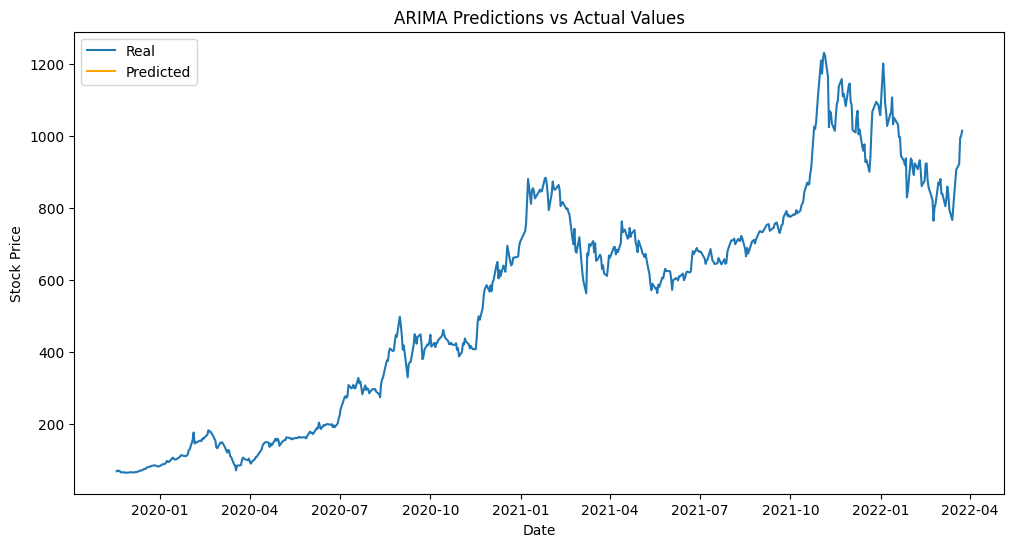

In [ ]:
# Add ARIMA predictions to test_data
test_data['ARIMAPredictions'] = predictions_arima

# Plot ARIMA predictions
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test_data.index, test_data['Close'], label='Real')
plt.plot(test_data.index, test_data['ARIMAPredictions'], color='orange', label='Predicted')
plt.title('ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


## RandomForest Model

In [ ]:
# Train RandomForest model
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train_rf, y_train)

# Make predictions
predictions_rf = model_rf.predict(X_test_rf)

In [ ]:
# Calculate MSE, MAE, and MAPE for RandomForest
mse_rf = mean_squared_error(y_test, predictions_rf)
mae_rf = mean_absolute_error(y_test, predictions_rf)
mape_rf = np.mean(np.abs((y_test - predictions_rf) / y_test)) * 100

print("RandomForest Mean Squared Error:", mse_rf)
print("RandomForest Mean Absolute Error:", mae_rf)
print("RandomForest Mean Absolute Percentage Error:", mape_rf)

RandomForest Mean Squared Error: 71.7191022928184
RandomForest Mean Absolute Error: 7.637523706155201
RandomForest Mean Absolute Percentage Error: 84.82176393364577


<ipython-input-70-2c178c86dea1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['RandomForestPredictions'] = np.nan  # Initialize with NaN values


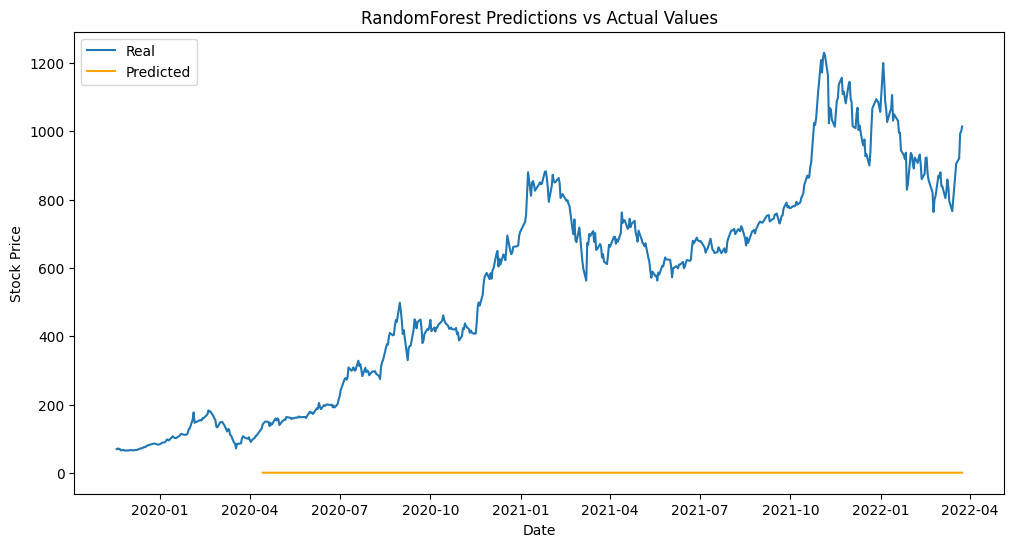

In [ ]:
# Add RandomForest predictions to test_data
test_data['RandomForestPredictions'] = np.nan  # Initialize with NaN values
test_data.loc[test_data.index[time_step:], 'RandomForestPredictions'] = predictions_rf  # Assign predictions to corresponding indices

# Plot RandomForest predictions
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test_data.index, test_data['Close'], label='Real')
plt.plot(test_data.index, test_data['RandomForestPredictions'], color='orange', label='Predicted')
plt.title('RandomForest Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
